In [6]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [125]:
data=pd.read_csv("datas/tickdata_3_加入技術.csv")

In [127]:
data_df=data.copy()
data_df['datetime']=pd.to_datetime(data_df['datetime'])
# 移除15:00~17:00以及03:00~04:00的資料
data_df_清洗 = data_df[
    (data_df["datetime"].dt.time >= pd.to_datetime("17:00:00").time())
    | (data_df["datetime"].dt.time <= pd.to_datetime("03:00:00").time())
]
data = data_df_清洗.head(10000)
data.drop(["datetime"], axis=1, inplace=True)

C:\Users\tseng\AppData\Local\Temp\ipykernel_26556\1519832654.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["datetime"], axis=1, inplace=True)


In [129]:
# 假設 data 是您的 dataframe
# 先定義特徵和目標變數
features = [
    "成交口數",
    "成交筆數",
    "主動買入筆數",
    "主動賣出筆數",
    "距離開盤時間分鐘數",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "高低點幅",
    "收漲跌幅",
    "近10分鐘的收漲跌幅",
    "近10分鐘高低點幅",
    "近10分鐘高點到現在的漲跌幅",
    "近10分鐘低點到現在的漲跌幅",
    "前10分鐘成交量總和",
    "近30分鐘的收漲跌幅",
    "近30分鐘高低點幅",
    "近30分鐘高點到現在的漲跌幅",
    "近30分鐘低點到現在的漲跌幅",
    "前30分鐘成交量總和",
    "近60分鐘的收漲跌幅",
    "近60分鐘高低點幅",
    "近60分鐘高點到現在的漲跌幅",
    "近60分鐘低點到現在的漲跌幅",
    "前60分鐘成交量總和",
    "近120分鐘的收漲跌幅",
    "近120分鐘高低點幅",
    "近120分鐘高點到現在的漲跌幅",
    "近120分鐘低點到現在的漲跌幅",
    "前120分鐘成交量總和",
    "台灣-美國高低掛",
    "星期幾",
    "vwap",
    "bollinger_upper",
    "bollinger_lower",
    "bollinger_bandwidth",
    "rsi",
    "macd_line",
    "signal_line",
    "%K",
    "%D",
    "atr",
]
targets = [
    "5分鐘後的漲跌幅",
    "10分鐘後的漲跌幅",
    "15分鐘後的漲跌幅",
    "20分鐘後的漲跌幅",
    "5分鐘後的震盪程度",
    "10分鐘後的震盪程度",
]

In [130]:
# 設定切分比例
train_size = 0.7
validation_size = 0.2
test_size = 0.1

# 按照比例切分數據
num_train = int(len(data) * train_size)
num_validation = int(len(data) * validation_size)

# 70% 訓練集, 20% 驗證集, 10% 測試集
train_data = data.iloc[:num_train]
validation_data = data.iloc[num_train : num_train + num_validation]
test_data = data.iloc[num_train + num_validation :]

# 獨立提取訓練、驗證、測試數據中的特徵和標籤
X_train, X_val, X_test = (
    train_data[features],
    validation_data[features],
    test_data[features],
)

In [131]:
results = {}

for target in targets:
    # 取出當前目標標籤
    y_train = train_data[target]
    y_val = validation_data[target]

    # LightGBM模型設定
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    # 設定參數
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.9,
    }
    callbacks = [lgb.log_evaluation(period=0), lgb.early_stopping(stopping_rounds=30)]

    # 模型訓練
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks,
    )

    # 驗證集預測與評估
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, val_preds)
    mse = mean_squared_error(y_val, val_preds)
    rmse = mse**0.5
    r2 = r2_score(y_val, val_preds)

    # 保存模型與評估結果
    results[target] = {"model": model, "mae": mae, "rmse": rmse, "r2": r2}
    print(f"{target} - 驗證集 MAE: {mae}, RMSE: {rmse}, R2: {r2}")

# 測試集數據（最後10%）獨立保存
X_test_df = test_data[features]
y_test_df = test_data[targets]

# 查看模型和驗證評估結果
results

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	training's l1: 3.7625	valid_1's l1: 4.2299
5分鐘後的漲跌幅 - 驗證集 MAE: 4.229895554624528, RMSE: 5.989905684529488, R2: 0.9959840038402271
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.87795	valid_1's l1: 4.36416
10分鐘後的漲跌幅 - 驗證集 MAE: 4.364157439645871, RMSE: 6.370081791876689, R2: -0.005708332103827818
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	training's l1: 7.02312	valid_1's l1: 11.2939
15分鐘後的漲跌幅 - 驗證集 MAE: 11.293949460564614, RMSE: 13.173184497330471, R2: 0.9806687511803438
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	training's l1: 8.58692	valid_1's l1: 6.11399
20分鐘後的漲跌幅 - 驗證集 MAE: 6.113986552030264, RMSE: 8.981790478736771, R2: -0.02136602480705263
Training until validation scores don't improve for 30 rounds
E

{'5分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x1930147be80>,
  'mae': 4.229895554624528,
  'rmse': 5.989905684529488,
  'r2': 0.9959840038402271},
 '10分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x193019fef10>,
  'mae': 4.364157439645871,
  'rmse': 6.370081791876689,
  'r2': -0.005708332103827818},
 '15分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x1930147b9a0>,
  'mae': 11.293949460564614,
  'rmse': 13.173184497330471,
  'r2': 0.9806687511803438},
 '20分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x193554958b0>,
  'mae': 6.113986552030264,
  'rmse': 8.981790478736771,
  'r2': -0.02136602480705263},
 '5分鐘後的震盪程度': {'model': <lightgbm.basic.Booster at 0x19355495850>,
  'mae': 2.4147310760493546,
  'rmse': 3.6493476450075484,
  'r2': 0.6996024427193053},
 '10分鐘後的震盪程度': {'model': <lightgbm.basic.Booster at 0x193554959a0>,
  'mae': 3.7403800908543623,
  'rmse': 5.623939001874795,
  'r2': 0.35179446991017715}}

不小心用到15~17的資料
{'5分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x19379254e20>,
  'mae': 5.976929196182163,
  'rmse': 8.437662549383322,
  'r2': 0.9674730855652108},
 '10分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x19354fb3040>,
  'mae': 5.199780764618469,
  'rmse': 8.316082466361356,
  'r2': 0.0003872160290515625},
 '15分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x1937925ddc0>,
  'mae': 11.04088633371555,
  'rmse': 14.539236128426772,
  'r2': 0.9059325992656813},
 '20分鐘後的漲跌幅': {'model': <lightgbm.basic.Booster at 0x19355495910>,
  'mae': 7.497906744257456,
  'rmse': 11.681175322267933,
  'r2': 0.0008817144021636691},
 '5分鐘後的震盪程度': {'model': <lightgbm.basic.Booster at 0x19379254ca0>,
  'mae': 2.582012182350503,
  'rmse': 5.199565526135134,
  'r2': 0.5507296354324613},
 '10分鐘後的震盪程度': {'model': <lightgbm.basic.Booster at 0x19354fb3f40>,
  'mae': 4.675908831904806,
  'rmse': 8.057666747706318,
  'r2': 0.9616651157616743}}

進行調參數

In [27]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [36]:
# 設定參數網格
param_grid = {
    "num_leaves": [15, 31, 63],
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [0.7, 0.9, 1.0],
    "max_depth": [-1, 5, 10],
    "min_data_in_leaf": [20, 50, 100],
}

# 保存結果的字典
results = {}

for target in targets:
    # 取出當前目標標籤
    y_train = train_data[target]
    y_val = validation_data[target]

    # LightGBM資料集設定
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    # 基礎參數設定
    base_params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "verbose": -1,
    }

    # 使用 GridSearchCV 進行參數調試
    grid_search = GridSearchCV(
        estimator=lgb.LGBMRegressor(**base_params),
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=3,
        verbose=1,
        n_jobs=-1,
    )

    # 訓練與調試模型
    grid_search.fit(X_train, y_train)

    # 最佳參數及模型
    best_params = grid_search.best_params_
    print(f"{target} 的最佳參數: {best_params}")

    # 使用最佳參數重新訓練模型
    best_model = lgb.train(
        {**base_params, **best_params},
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.log_evaluation(period=0),
            lgb.early_stopping(stopping_rounds=30),
        ],
    )

    # 驗證集預測與評估
    val_preds = best_model.predict(X_val, num_iteration=best_model.best_iteration)
    mae = mean_absolute_error(y_val, val_preds)
    mse = mean_squared_error(y_val, val_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, val_preds)

    # 保存最佳模型與評估結果
    results[target] = {
        "best_params": best_params,
        "model": best_model,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
    }
    print(f"{target} - 驗證集 MAE: {mae}, RMSE: {rmse}, R2: {r2}")

# 測試集數據（最後10%）獨立保存
X_test_df = test_data[features]
y_test_df = test_data[targets]

# 查看模型和驗證評估結果
results

ValueError: Found input variables with inconsistent numbers of samples: [10598, 9273]

{'5分鐘後的漲跌幅': {'best_params': {'feature_fraction': 1.0,
   'learning_rate': 0.1,
   'max_depth': 10,
   'min_data_in_leaf': 50,
   'num_leaves': 63},
  'model': <lightgbm.basic.Booster at 0x193797aef70>,
  'mae': 4.140884333901451,
  'rmse': 7.253347077642465,
  'r2': 0.9759632647087725},
 '10分鐘後的漲跌幅': {'best_params': {'feature_fraction': 0.7,
   'learning_rate': 0.01,
   'max_depth': 5,
   'min_data_in_leaf': 50,
   'num_leaves': 15},
  'model': <lightgbm.basic.Booster at 0x19379810c70>,
  'mae': 5.1997611384237254,
  'rmse': 8.316377539024101,
  'r2': 0.0003162779064544985},
 '15分鐘後的漲跌幅': {'best_params': {'feature_fraction': 0.9,
   'learning_rate': 0.1,
   'max_depth': -1,
   'min_data_in_leaf': 50,
   'num_leaves': 63},
  'model': <lightgbm.basic.Booster at 0x1937990d040>,
  'mae': 8.744981931392601,
  'rmse': 12.586364100580159,
  'r2': 0.929505287140113},
 '20分鐘後的漲跌幅': {'best_params': {'feature_fraction': 0.7,
   'learning_rate': 0.01,
   'max_depth': 5,
   'min_data_in_leaf': 50,
   'num_leaves': 31},
  'model': <lightgbm.basic.Booster at 0x1937991a160>,
  'mae': 7.5039547594316085,
  'rmse': 11.68787689535819,
  'r2': -0.00026501693385050373},
 '5分鐘後的震盪程度': {'best_params': {'feature_fraction': 0.9,
   'learning_rate': 0.1,
   'max_depth': -1,
   'min_data_in_leaf': 50,
   'num_leaves': 31},
  'model': <lightgbm.basic.Booster at 0x193799050a0>,
  'mae': 2.60228862412076,
  'rmse': 5.246861227711147,
  'r2': 0.5425192584897626},
 '10分鐘後的震盪程度': {'best_params': {'feature_fraction': 0.7,
   'learning_rate': 0.1,
   'max_depth': 5,
   'min_data_in_leaf': 20,
   'num_leaves': 15},
  'model': <lightgbm.basic.Booster at 0x193797e78e0>,
  'mae': 4.636152496565654,
  'rmse': 8.152334070462786,
  'r2': 0.9607590521591353}}

In [9]:
X_test

,成交口數,成交筆數,主動買入筆數,主動賣出筆數,距離開盤時間分鐘數,open,high,low,close,volume,...,vwap,bollinger_upper,bollinger_lower,bollinger_bandwidth,rsi,macd_line,signal_line,%K,%D,atr
15453,0.0,0,0,0,40,43142.0,43150.0,43141.0,43146.0,65,...,40935.254409,43174.940053,43117.659947,0.001328,38.938053,9.095754,12.656620,46.031746,40.740741,16.357143
15454,0.0,0,0,0,45,43145.0,43157.0,43142.0,43157.0,29,...,40935.262531,43175.391813,43117.608187,0.001339,47.826087,9.840683,12.093433,63.492063,48.677249,16.357143
15455,3.0,1,1,0,50,43157.0,43164.0,43153.0,43156.0,64,...,40935.280446,43175.968115,43117.631885,0.001352,42.452830,10.232401,11.721227,61.904762,57.142857,15.214286
15456,3.0,3,2,1,55,43156.0,43172.0,43156.0,43169.0,71,...,40935.300437,43177.914190,43116.885810,0.001414,61.702128,11.459730,11.668927,94.545455,73.314093,13.785714
15457,5.0,4,0,4,60,43168.0,43168.0,43142.0,43147.0,153,...,40935.343090,43177.303726,43116.696274,0.001405,51.785714,10.535732,11.442288,54.545455,70.331890,14.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17166,0.0,0,0,0,755,42668.0,42668.0,42643.0,42652.0,553,...,41155.979456,42663.707163,42606.092837,0.001351,55.844156,7.048910,5.173271,74.358974,78.205128,28.071429
17167,0.0,0,0,0,760,42654.0,42667.0,42650.0,42654.0,386,...,41156.044681,42666.028878,42606.271122,0.001402,56.709957,7.627174,5.664052,76.923077,82.051282,27.714286
17168,0.0,0,0,0,765,42656.0,42658.0,42637.0,42640.0,502,...,41156.128706,42665.859748,42606.240252,0.001398,51.282051,6.876501,5.906542,58.974359,70.085470,27.357143
17169,0.0,0,0,0,770,42641.0,42641.0,42613.0,42624.0,593,...,41156.226880,42665.793303,42605.206697,0.001421,50.632911,4.933649,5.711963,38.461538,58.119658,27.571429


把調參數的結果再做一次

In [11]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [108]:

# 定義特徵和目標
features = [
    "成交口數",
    "成交筆數",
    "主動買入筆數",
    "主動賣出筆數",
    "距離開盤時間分鐘數",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "高低點幅",
    "收漲跌幅",
    "近10分鐘的收漲跌幅",
    "近10分鐘高低點幅",
    "近10分鐘高點到現在的漲跌幅",
    "近10分鐘低點到現在的漲跌幅",
    "前10分鐘成交量總和",
    "近30分鐘的收漲跌幅",
    "近30分鐘高低點幅",
    "近30分鐘高點到現在的漲跌幅",
    "近30分鐘低點到現在的漲跌幅",
    "前30分鐘成交量總和",
    "近60分鐘的收漲跌幅",
    "近60分鐘高低點幅",
    "近60分鐘高點到現在的漲跌幅",
    "近60分鐘低點到現在的漲跌幅",
    "前60分鐘成交量總和",
    "近120分鐘的收漲跌幅",
    "近120分鐘高低點幅",
    "近120分鐘高點到現在的漲跌幅",
    "近120分鐘低點到現在的漲跌幅",
    "前120分鐘成交量總和",
    "台灣-美國高低掛",
    "星期幾",
    "vwap",
    "bollinger_upper",
    "bollinger_lower",
    "bollinger_bandwidth",
    "rsi",
    "macd_line",
    "signal_line",
    "%K",
    "%D",
    "atr",
]
target = "5分鐘後的漲跌幅"

# 假設 data 是您的 dataframe
# 將數據分為訓練集、驗證集和測試集
X = data[features]
y = data[target]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# 使用先前最佳參數
best_params = {
    "feature_fraction": 1.0,
    "learning_rate": 0.1,
    "max_depth": 10,
    "min_data_in_leaf": 50,
    "num_leaves": 63,
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "verbose": -1,
}

# 建立LightGBM資料集
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# 訓練模型
model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=30)],
)

# 預測測試集
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

# 評估模型表現
mae = mean_absolute_error(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_preds)
print(f"測試集評估結果 - MAE: {mae}, RMSE: {rmse}, R2: {r2}")

# 保存預測結果至CSV
output_df = X_test.copy()
output_df["true_value"] = y_test
output_df["predicted_value"] = test_preds
output_df.to_csv("datas/predictions.csv", index=False)
print("預測結果已保存為 predictions.csv")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	training's l1: 3.20254	valid_1's l1: 3.72992
測試集評估結果 - MAE: 3.819544460728803, RMSE: 6.420997659014489, R2: 0.9879722926786076
預測結果已保存為 predictions.csv


In [62]:
X_test

,成交口數,成交筆數,主動買入筆數,主動賣出筆數,距離開盤時間分鐘數,open,high,low,close,volume,...,vwap,bollinger_upper,bollinger_lower,bollinger_bandwidth,rsi,macd_line,signal_line,%K,%D,atr
5639,0.0,0,0,0,290,40792.0,40793.0,40785.0,40788.0,23,...,40128.849484,40804.639920,40784.560080,0.000492,36.000000,-4.094517,-3.663154,29.629630,34.567901,10.142857
2334,2.0,2,2,0,250,40881.0,40887.0,40873.0,40873.0,151,...,40267.615931,40913.759681,40833.440319,0.001965,43.478261,-0.261845,-0.958544,38.372093,46.124031,24.642857
924,0.0,0,0,0,265,39716.0,39721.0,39713.0,39721.0,169,...,39590.838147,39722.662878,39676.837122,0.001154,64.285714,4.623032,1.777943,100.000000,94.308943,9.571429
4391,4.0,3,2,1,330,39435.0,39459.0,39432.0,39443.0,269,...,40236.942408,39499.684405,39414.515595,0.002159,30.081301,-4.953951,0.191082,39.325843,26.152092,28.000000
5866,0.0,0,0,0,640,40934.0,40950.0,40934.0,40949.0,226,...,40149.929489,40992.330187,40925.069813,0.001642,44.508671,-3.222824,-1.679632,47.368421,40.350877,25.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12860,4.0,4,0,4,510,41956.0,41957.0,41926.0,41939.0,137,...,40528.306967,42526.100832,41713.699168,0.019288,50.214432,-14.683704,-13.801363,18.007663,44.740106,409.642857
7947,1.0,1,0,1,240,40670.0,40686.0,40665.0,40675.0,145,...,40362.344807,40689.063610,40624.236390,0.001595,67.187500,19.481542,21.764857,77.192982,75.175439,18.285714
9736,7.0,3,3,0,530,40853.0,40864.0,40821.0,40835.0,1019,...,40388.656517,41453.335269,40651.764731,0.019525,49.853049,-8.275734,1.589597,3.326403,33.040669,412.214286
8822,0.0,0,0,0,170,41027.0,41027.0,41027.0,41027.0,1,...,40378.726625,41211.346751,40420.153249,0.019385,50.212295,-10.923302,-7.370826,14.350797,40.642546,395.000000


In [132]:
data = pd.read_csv("datas/tickdata_3_加入技術.csv")

In [133]:
data_df = data.copy()
data_df["datetime"] = pd.to_datetime(data_df["datetime"])
# 移除15:00~17:00以及03:00~04:00的資料
data_df_清洗 = data_df[
    (data_df["datetime"].dt.time >= pd.to_datetime("17:00:00").time())
    | (data_df["datetime"].dt.time <= pd.to_datetime("03:00:00").time())
]
data=data_df_清洗


In [134]:
data_test_origin = data.tail(3000)
data_test = data_test_origin.drop(
    columns=[
        "datetime",
        "5分鐘後的漲跌幅",
        "10分鐘後的漲跌幅",
        "15分鐘後的漲跌幅",
        "20分鐘後的漲跌幅",
        "5分鐘後的震盪程度",
        "10分鐘後的震盪程度",
    ]
)

data_test

,成交口數,成交筆數,主動買入筆數,主動賣出筆數,距離開盤時間分鐘數,open,high,low,close,volume,...,vwap,bollinger_upper,bollinger_lower,bollinger_bandwidth,rsi,macd_line,signal_line,%K,%D,atr
13296,2.0,2,0,2,245,42496.0,42501.0,42473.0,42484.0,383,...,40593.241824,42608.986808,42506.513192,0.002408,16.101695,-11.651550,-1.508570,9.734513,4.414428,17.357143
13297,0.0,0,0,0,250,42482.0,42485.0,42472.0,42477.0,250,...,40593.314031,42616.171587,42490.928413,0.002943,13.114754,-15.915065,-4.389869,4.385965,4.706826,17.428571
13298,0.0,0,0,0,255,42477.0,42499.0,42477.0,42494.0,178,...,40593.365903,42618.172169,42482.327831,0.003193,23.913043,-17.717932,-7.055481,19.298246,11.139575,18.214286
13299,0.0,0,0,0,260,42495.0,42510.0,42494.0,42510.0,67,...,40593.385591,42617.011664,42477.688336,0.003275,31.818182,-17.652167,-9.174818,33.333333,19.005848,18.928571
13300,0.0,0,0,0,265,42511.0,42520.0,42502.0,42520.0,157,...,40593.431966,42615.040590,42474.959410,0.003293,34.782609,-16.601757,-10.660206,42.105263,31.578947,19.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17155,0.0,0,0,0,700,42635.0,42643.0,42618.0,42621.0,472,...,41155.099851,42663.423331,42594.476669,0.001617,41.333333,5.082687,7.489584,24.489796,34.197846,24.071429
17156,0.0,0,0,0,705,42621.0,42636.0,42611.0,42636.0,363,...,41155.160525,42663.489419,42597.210581,0.001555,50.993377,5.252490,7.042165,55.102041,43.537415,24.357143
17157,2.0,1,1,0,710,42635.0,42672.0,42635.0,42658.0,770,...,41155.291122,42659.146222,42609.553778,0.001163,53.750000,7.080655,7.049863,77.777778,52.456538,25.285714
17158,0.0,0,0,0,715,42657.0,42657.0,42614.0,42619.0,482,...,41155.370739,42658.011613,42611.588387,0.001089,44.791667,5.321176,6.704126,15.873016,49.584278,27.142857


In [135]:
data_test_origin

,datetime,5分鐘後的漲跌幅,10分鐘後的漲跌幅,15分鐘後的漲跌幅,20分鐘後的漲跌幅,5分鐘後的震盪程度,10分鐘後的震盪程度,成交口數,成交筆數,主動買入筆數,...,vwap,bollinger_upper,bollinger_lower,bollinger_bandwidth,rsi,macd_line,signal_line,%K,%D,atr
13296,2024-09-24 19:05:00,-1.647679,2.353827,6.119951,8.473778,3.059976,6.355334,2.0,2,0,...,40593.241824,42608.986808,42506.513192,0.002408,16.101695,-11.651550,-1.508570,9.734513,4.414428,17.357143
13297,2024-09-24 19:10:00,4.002166,7.768910,10.123125,14.360713,5.179273,7.768910,0.0,0,0,...,40593.314031,42616.171587,42490.928413,0.002943,13.114754,-15.915065,-4.389869,4.385965,4.706826,17.428571
13298,2024-09-24 19:15:00,3.765237,6.118511,10.354403,16.708241,3.765237,6.118511,0.0,0,0,...,40593.365903,42618.172169,42482.327831,0.003193,23.913043,-17.717932,-7.055481,19.298246,11.139575,18.214286
13299,2024-09-24 19:20:00,2.352388,6.586685,12.938132,11.526700,4.234298,10.115267,0.0,0,0,...,40593.385591,42617.011664,42477.688336,0.003275,31.818182,-17.652167,-9.174818,33.333333,19.005848,18.928571
13300,2024-09-24 19:25:00,4.233302,10.583255,9.172154,11.288805,6.820320,12.229539,0.0,0,0,...,40593.431966,42615.040590,42474.959410,0.003293,34.782609,-16.601757,-10.660206,42.105263,31.578947,19.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17155,2024-10-29 02:40:00,3.519392,8.681167,-0.469252,4.692522,5.865653,14.312194,0.0,0,0,...,41155.099851,42663.423331,42594.476669,0.001617,41.333333,5.082687,7.489584,24.489796,34.197846,24.071429
17156,2024-10-29 02:45:00,5.159959,-3.987241,1.172718,-3.752697,8.678112,13.603528,0.0,0,0,...,41155.160525,42663.489419,42597.210581,0.001555,50.993377,5.252490,7.042165,55.102041,43.537415,24.357143
17157,2024-10-29 02:50:00,-9.142482,-3.985184,-8.908059,-7.735946,10.080173,14.768625,2.0,1,1,...,41155.291122,42659.146222,42609.553778,0.001163,53.750000,7.080655,7.049863,77.777778,52.456538,25.285714
17158,2024-10-29 02:55:00,5.162017,0.234637,1.407823,-1.173186,12.435768,12.435768,0.0,0,0,...,41155.370739,42658.011613,42611.588387,0.001089,44.791667,5.321176,6.704126,15.873016,49.584278,27.142857


In [136]:
# 預測測試集
test_preds = model.predict(data_test, num_iteration=model.best_iteration)


# 保存預測結果至CSV
output_df = data_test.copy()
output_df["predicted_value"] = test_preds
output_df = pd.concat(
    [
        data_test_origin[
            "datetime"
        ],
        output_df,
    ],
    axis=1,
)
output_df.to_csv("datas/predictions.csv", index=False)
print("預測結果已保存為 predictions.csv")


預測結果已保存為 predictions.csv


In [137]:
r2 = r2_score(data_test_origin["5分鐘後的漲跌幅"], test_preds)
r2

-7.476249533646202

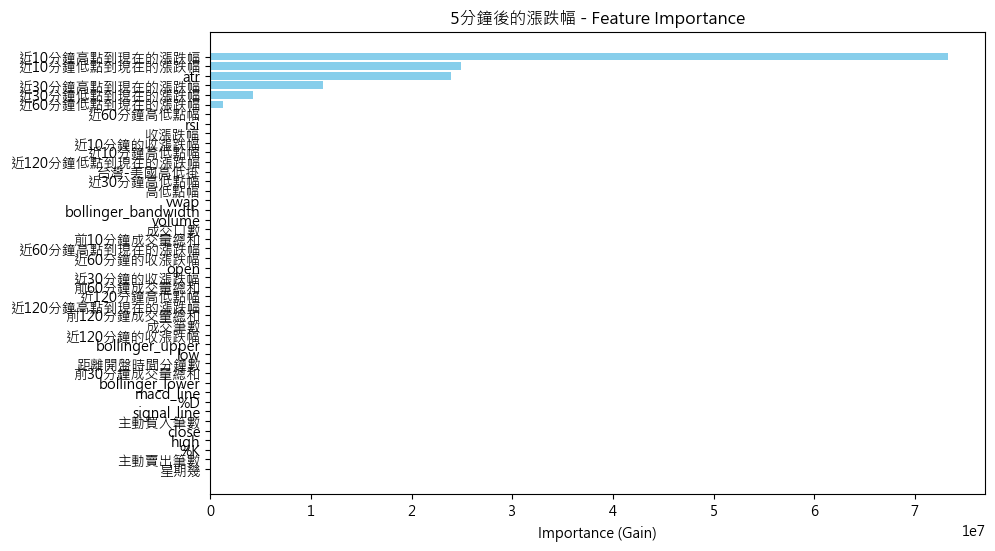

In [110]:
import matplotlib.pyplot as plt


def plot_feature_importance(model, model_name):
    # 獲取特徵重要性
    importance = model.feature_importance(importance_type="gain")
    feature_names = X.columns
    feature_importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": importance}
    )
    feature_importance_df = feature_importance_df.sort_values(
        by="Importance", ascending=False
    )

    # 繪製條形圖
    plt.figure(figsize=(10, 6))
    plt.barh(
        feature_importance_df["Feature"],
        feature_importance_df["Importance"],
        color="skyblue",
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Importance (Gain)")
    plt.title(f"{model_name} - Feature Importance")
    plt.show()


# 查看每個模型的特徵重要性
plot_feature_importance(model, "5分鐘後的漲跌幅")


In [46]:
data.iloc[-1]

datetime               2024-10-29 03:00:00
5分鐘後的漲跌幅                         -4.924838
10分鐘後的漲跌幅                        -3.752257
15分鐘後的漲跌幅                        -6.331934
20分鐘後的漲跌幅                         0.703548
5分鐘後的震盪程度                          6.56645
10分鐘後的震盪程度                         6.56645
成交口數                                   1.0
成交筆數                                     1
主動買入筆數                                   0
主動賣出筆數                                   1
距離開盤時間分鐘數                              720
open                               42617.0
high                               42647.0
low                                42594.0
close                              42641.0
volume                                 790
高低點幅                              0.001244
收漲跌幅                              0.000563
近10分鐘的收漲跌幅                       -0.039852
近10分鐘高低點幅                         0.147686
近10分鐘高點到現在的漲跌幅                    0.037523
近10分鐘低點到現在的漲跌幅                   -0.110223
前10分鐘成交量總和 